## Import Data ##

In [676]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [678]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

## Statistical Modeling ##

In [681]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [683]:
pd_data.shape

(2708, 1433)

In [685]:
pd_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,1.000000,-0.008563,0.017806,-0.012741,0.040793,-0.003925,-0.008021,-0.004196,-0.008431,-0.003633,...,0.032953,-0.012650,-0.010246,0.007833,0.039753,-0.002567,-0.008693,-0.003633,-0.012090,-0.005143
1,-0.008563,1.000000,-0.018093,-0.018356,0.027991,-0.005654,-0.011556,-0.006046,-0.012146,-0.005234,...,-0.005805,0.002839,0.011011,-0.023284,-0.011353,-0.003699,-0.012524,-0.005234,-0.017418,-0.007410
2,0.017806,-0.018093,1.000000,-0.012457,0.046063,-0.008293,-0.016948,-0.008867,-0.017813,-0.007676,...,0.025422,-0.026729,-0.021649,-0.010972,-0.016650,-0.005425,0.023431,-0.007676,0.004862,-0.010868
3,-0.012741,-0.018356,-0.012457,1.000000,-0.022906,-0.008414,-0.017195,-0.008996,0.003169,-0.007788,...,0.012504,0.015978,-0.021964,0.011076,-0.016893,-0.005504,-0.018636,-0.007788,-0.010921,-0.011026
4,0.040793,0.027991,0.046063,-0.022906,1.000000,-0.012967,-0.011504,-0.013865,0.029290,-0.012003,...,0.010148,-0.032135,0.048896,-0.007273,-0.010775,-0.008483,-0.028723,-0.012003,0.020571,0.006248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,-0.002567,-0.003699,-0.005425,-0.005504,-0.008483,-0.001695,-0.003465,-0.001813,-0.003642,-0.001569,...,-0.006853,-0.005465,-0.004426,-0.006981,-0.003404,1.000000,-0.003755,-0.001569,-0.005223,-0.002222
1429,-0.008693,-0.012524,0.023431,-0.018636,-0.028723,-0.005740,-0.011732,-0.006138,0.018360,0.065222,...,-0.023203,-0.018503,-0.014986,0.042423,-0.011526,-0.003755,1.000000,-0.005314,0.003985,-0.007523
1430,-0.003633,-0.005234,-0.007676,-0.007788,-0.012003,-0.002399,-0.004903,-0.002565,-0.005153,-0.002221,...,-0.009696,-0.007732,-0.006263,-0.009879,-0.004817,-0.001569,-0.005314,1.000000,0.043923,-0.003144
1431,-0.012090,-0.017418,0.004862,-0.010921,0.020571,-0.007984,-0.016316,-0.008536,-0.017149,-0.007390,...,-0.032269,-0.010633,-0.002367,0.027197,0.031671,-0.005223,0.003985,0.043923,1.000000,0.025861


In [686]:
pd_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,0.005908,0.012186,0.025849,0.026588,0.060931,0.002585,0.010709,0.002954,0.011817,0.002216,...,0.040620,0.026219,0.017356,0.042097,0.010340,0.001108,0.012555,0.002216,0.024003,0.004431
std,0.076654,0.109737,0.158714,0.160904,0.239247,0.050786,0.102947,0.054282,0.108080,0.047027,...,0.197444,0.159812,0.130618,0.200847,0.101176,0.033272,0.111367,0.047027,0.153086,0.066433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [687]:
def data_to_nx_subgraph(data, node_range):
    G = nx.Graph()

    selected_nodes = list(node_range)

    G.add_nodes_from(selected_nodes)

    edge_index = data.edge_index
    edges = edge_index.t().tolist()
    
    filtered_edges = [(u, v) for u, v in edges if u in selected_nodes and v in selected_nodes]
    
    G.add_edges_from(filtered_edges)

    return G

node_range = range(1, 200)

G = data_to_nx_subgraph(data, node_range)

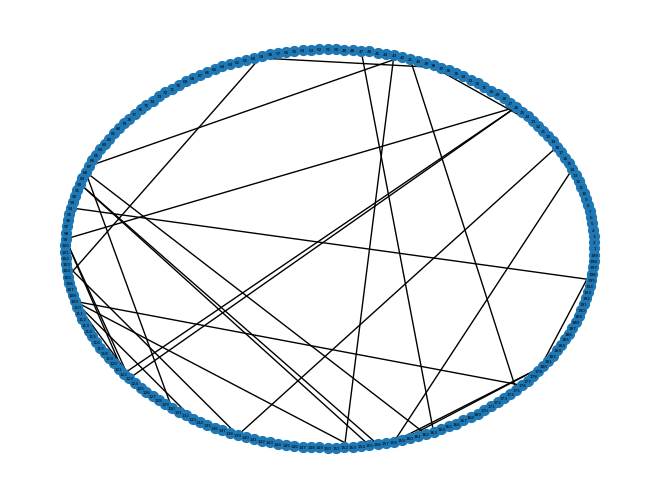

In [688]:
nx.draw_circular(G, with_labels=True, node_size=50, font_size=3)
plt.show()

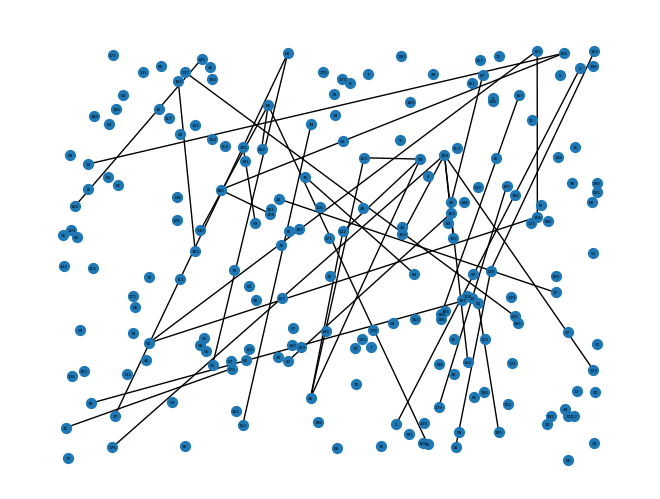

In [689]:
nx.draw_random(G, with_labels=True, node_size=50, font_size=3)
plt.show()

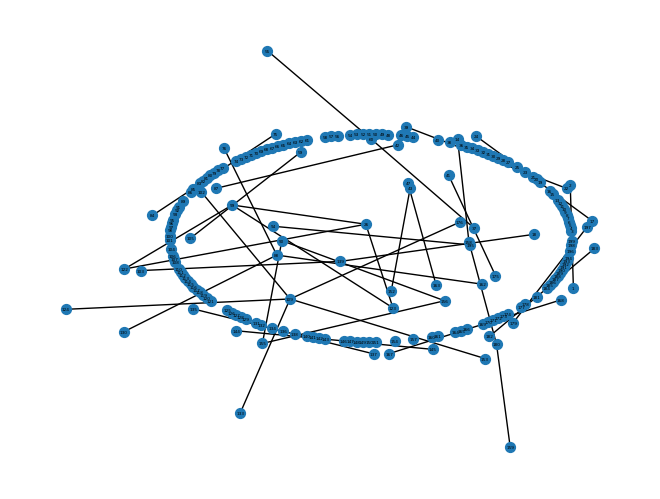

In [690]:
nx.draw_kamada_kawai(G, with_labels=True, node_size=50, font_size=3)

## Training Model ##

In [691]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [692]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [698]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           16
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       22,928
├─GCNConv: 1-2                           7
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       112
Total params: 23,063
Trainable params: 23,063
Non-trainable params: 0

In [703]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [705]:
start_time = time.time()

for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 1.9426, Test Accuracy: 0.5400
Epoch: 10, Loss: 0.5136, Test Accuracy: 0.7970
Epoch: 20, Loss: 0.0801, Test Accuracy: 0.7830
Epoch: 30, Loss: 0.0179, Test Accuracy: 0.7830
Epoch: 40, Loss: 0.0072, Test Accuracy: 0.7790
Epoch: 50, Loss: 0.0042, Test Accuracy: 0.7790
Epoch: 60, Loss: 0.0031, Test Accuracy: 0.7810
Epoch: 70, Loss: 0.0026, Test Accuracy: 0.7810
Epoch: 80, Loss: 0.0022, Test Accuracy: 0.7800
Epoch: 90, Loss: 0.0019, Test Accuracy: 0.7800
Epoch: 100, Loss: 0.0017, Test Accuracy: 0.7800
Epoch: 110, Loss: 0.0016, Test Accuracy: 0.7780
Epoch: 120, Loss: 0.0014, Test Accuracy: 0.7770
Epoch: 130, Loss: 0.0013, Test Accuracy: 0.7790
Epoch: 140, Loss: 0.0012, Test Accuracy: 0.7790
Epoch: 150, Loss: 0.0011, Test Accuracy: 0.7790
Epoch: 160, Loss: 0.0010, Test Accuracy: 0.7810
Epoch: 170, Loss: 0.0009, Test Accuracy: 0.7810
Epoch: 180, Loss: 0.0009, Test Accuracy: 0.7810
Epoch: 190, Loss: 0.0008, Test Accuracy: 0.7810

Training Time is:  0.5233  Seconds


## Post-Training Analysis ##

In [707]:
torch.save(model.state_dict(), "First_GNN.pth")

In [709]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("First_GNN.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

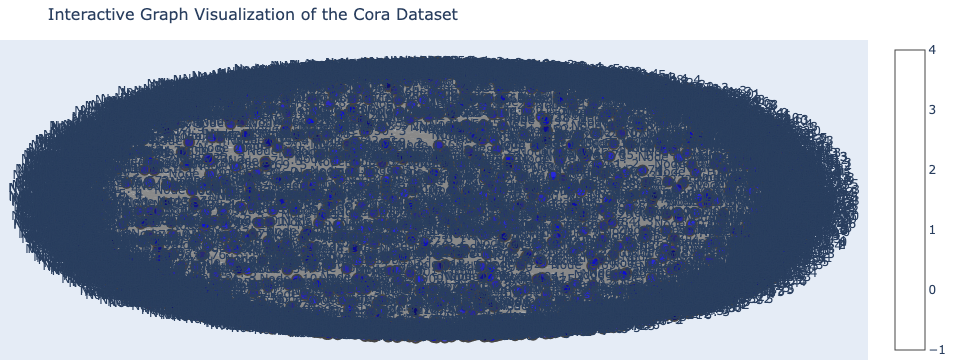

In [727]:
def plot_interactive_graph():
    edge_index = data.edge_index.cpu().numpy()
    G = nx.Graph()

    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])

    labels = {i: dataset[0].y[i].item() for i in range(data.num_nodes)}
    colors = np.array([dataset[0].y[i].item() for i in range(data.num_nodes)])

    pos = nx.spring_layout(G, k=0.5, iterations=50)

    header = str(dataset).replace("(","").replace(")","")

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x = []
    node_y = []
    node_color = []
    for i in range(data.num_nodes):
        x, y = pos[i]
        node_x.append(x)
        node_y.append(y)
        node_color.append(f'rgba(0, 0, {255 - (colors[i] * 25)}, 0.7)')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(showscale=True,
                    colorscale='Blues',
                    size=10,
                    color=node_color,
                    line=dict(width=2)),
        text=[f'Node {i}: {labels[i]}' for i in range(data.num_nodes)]
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Interactive Graph Visualization of the {header} Dataset',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))

    pyo.iplot(fig)

plot_interactive_graph()